In [1]:
import os

In [2]:
data_dir = "/home/aniket/Projects/github/expensify/data"
train_data_dir = f"{data_dir}/train"
val_data_dir = f"{data_dir}/valid"
test_data_dir = f"{data_dir}/test"

!head -n 5 {train_data_dir}/annotations.jsonl

{"image": "28e5d986-d6b9-412d-9f0c-b9eafb998726_jpg.rf.dea5bc5b319b7f1c846a8b516289b308.jpg", "prefix": "<VQA>Given the following receipt, extract the total amount spent.", "suffix": "{\"total\": 40.0 }"}
{"image": "1063-receipt_jpg.rf.dd3b96697a341e071224e87c522eddf4.jpg", "prefix": "<VQA>Given the following receipt, extract the total amount spent.", "suffix": "{\"total\": 52.47}"}
{"image": "1044-receipt_jpg.rf.dc49382166edc6382e9a0d2e8308235a.jpg", "prefix": "<VQA>Given the following receipt, extract the total amount spent.", "suffix": "{\"total\": 10.94}"}
{"image": "360_F_182011806_mxcDzt9ckBYbGpxAne8o73DbyDHpXOe9_jpg.rf.e1fee9b531061ddc256a4b85e7ca7e39.jpg", "prefix": "<VQA>Given the following receipt, extract the total amount spent.", "suffix": "{\"total\": 84.80}"}
{"image": "1124-receipt_jpg.rf.e1add367615a515002271061a28d994e.jpg", "prefix": "<VQA>Given the following receipt, extract the total amount spent.", "suffix": "{\"total\": 83.64}"}


In [3]:
import json
import os
from typing import Any


def modify_jsonl(file_path: str, task: str) -> None:
    temp_file_path: str = file_path + ".temp"

    with open(file_path) as infile, open(temp_file_path, "w") as outfile:
        for line in infile:
            data: dict[str, Any] = json.loads(line.strip())
            data["prefix"] = f"<VQA>{task}"
            outfile.write(json.dumps(data) + "\n")

    os.replace(temp_file_path, file_path)

In [4]:
# task = "Given the following receipt, extract the total amount spent."
# modify_jsonl(f"{data_dir}/train/annotations.jsonl", task)
# modify_jsonl(f"{data_dir}/test/annotations.jsonl", task)
# modify_jsonl(f"{data_dir}/valid/annotations.jsonl", task)

In [ ]:
!maestro florence2 train --help

In [ ]:
!maestro florence2 train --dataset={data_dir} \
--epochs=3 --batch_size=4 --lr=2e-6 \
--metrics word_error_rate --metrics character_error_rate 


In [1]:
from maestro.trainer.models.florence_2.checkpoints import load_model

processor, model = load_model(model_id_or_path="/home/aniket/Projects/github/expensify/training/florence-2/2/checkpoints/best")

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, 

In [26]:
from maestro.trainer.common.data_loaders.datasets import JSONLDataset


ds = JSONLDataset(
    jsonl_file_path=f"{data_dir}/test/annotations.jsonl", image_directory_path=f"{data_dir}/test/"
)

image, annotations = ds[1]
text = annotations["prefix"]

inputs = processor(text=text, images=image, return_tensors="pt").to("cuda")
generated_ids = model.generate(
    input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"], max_new_tokens=10, num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("question:", text)
print("answare:", generated_text)


question: <VQA>Given the following receipt, extract the total amount spent.
answare: $22.87


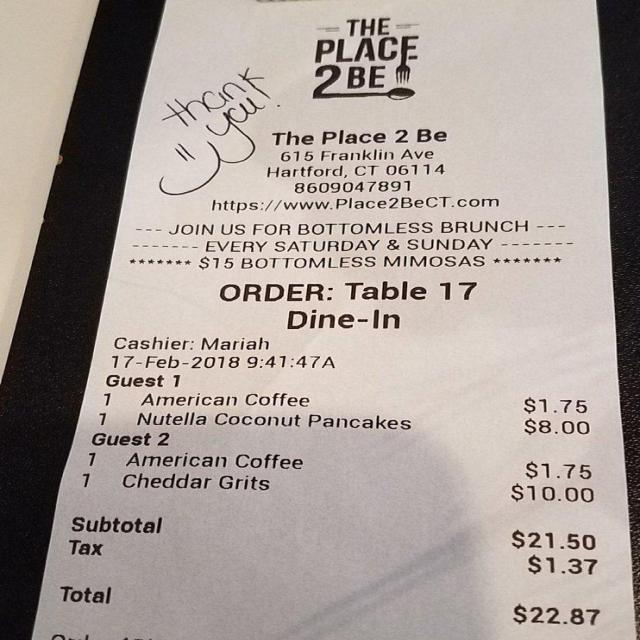

In [27]:
image